In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# conn = sqlite3.connect("./backup/database_2024-08-12_09-23-18.db")

conn = sqlite3.connect("database.db")

sql = """
SELECT 
    BuergerBuero.stadt AS stadt,
    Termin.buergerbuero AS buergerbuero,
    Termin.datum AS datum,
    Termin.angelegenheit AS angelegenheit,
    Termin.erstmalsErfasstAlsFrei AS angelegt,
    Termin.erstmalsErfasstAlsBelegt AS belegt
FROM Termin
INNER JOIN BuergerBuero ON Termin.buergerbuero = BuergerBuero.stadtteil;
"""

df = pd.read_sql_query(sql, conn, parse_dates=["datum", "angelegt", "belegt"])
df.head()

,stadt,buergerbuero,datum,angelegenheit,angelegt,belegt
0,Dresden,Cotta,2024-08-19 09:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 16:41:58.374892
1,Dresden,Cotta,2024-08-26 11:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
2,Dresden,Cotta,2024-08-26 11:30:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
3,Dresden,Cotta,2024-08-26 11:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666
4,Dresden,Cotta,2024-08-26 12:00:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,2024-08-12 19:10:29.070666


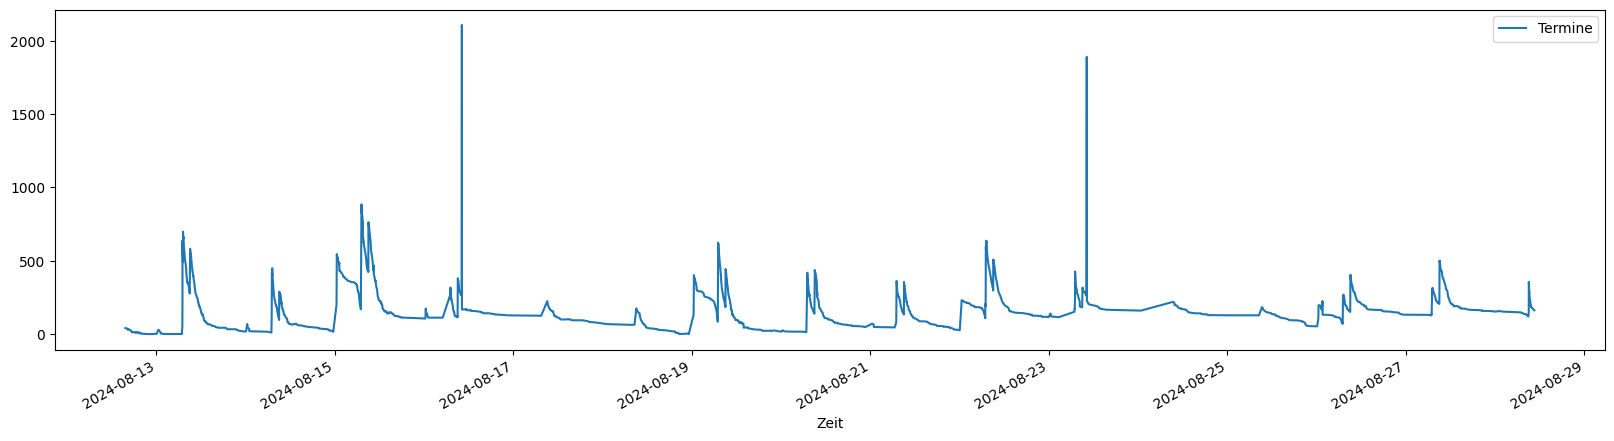

In [135]:
# alle Termine in Düsseldorf

df_city = df[df["stadt"] == "Duesseldorf"]  # 14 323 Termine

# sortiere aufsteigend nach belegt-Zeitpunkt

timestamps = df_city["belegt"].sort_values().unique()


count_open_per_timestamp = []

for timestamp in timestamps:

    # pro Zeitpunkt: wie viele Termine sind offen?
    # Termine sind zu einem Zeitpunkt offen, wenn ...
    count = df_city[
        # - der Anlegezeitpunkt vor (oder auf) dem Zeitpunkt liegt und ...
        (df_city["angelegt"] <= timestamp)
        # - der Belegtzeitpunkt entweder nach dem Zeitpunkt liegt oder gar nicht gesetzt ist
        & ((timestamp < df_city["belegt"]) | (df_city["belegt"].isnull()))
    ].shape[0]
    count_open_per_timestamp.append(count)

open = pd.DataFrame(
    {"Zeit": timestamps, "Termine": count_open_per_timestamp}
)

# plotte die Anzahl der offenen Termine pro belegt-Zeitpunkt
open.plot(x="Zeit", y="Termine", kind="line", figsize=(20, 5))

plt.show()

In [136]:
open.sort_values("anzahl_offen", ascending=False).head(10)

KeyError: 'anzahl_offen'

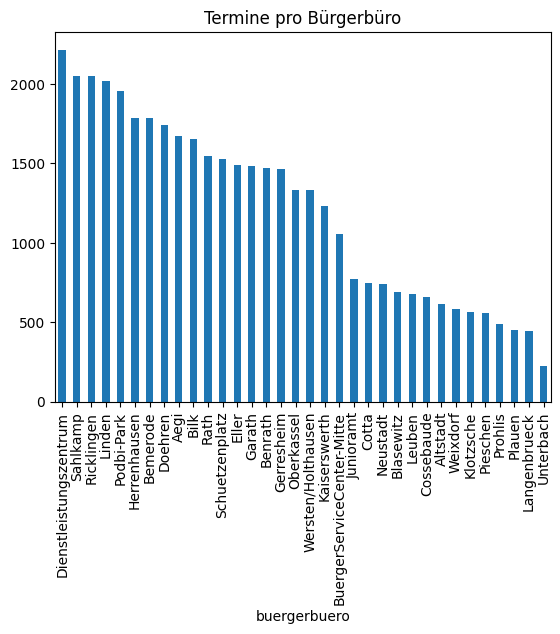

In [ ]:
# Termine pro Bürgerbüro

df.buergerbuero.value_counts().plot(kind="bar")
plt.title("Termine pro Bürgerbüro")
plt.show()


In [ ]:
# offene Termine pro Bürgerbüro
count_open_per_timestamp = df[df["belegt"].isnull()]
count_open_per_timestamp
# open_appointments = df[df["stadt"] == city].groupby("buergerbuero").offen.sum().sort_values(ascending=False)
# open_appointments.plot(kind="bar")

# plt.title("Offene Termine pro Bürgerbüro")
# plt.show()

,stadt,buergerbuero,datum,angelegenheit,angelegt,belegt
2372,Dresden,Plauen,2024-09-20 11:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2374,Dresden,Plauen,2024-09-20 11:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2381,Dresden,Plauen,2024-09-23 09:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2382,Dresden,Plauen,2024-09-23 09:30:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2383,Dresden,Plauen,2024-09-23 09:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
...,...,...,...,...,...,...
41066,Duesseldorf,Dienstleistungszentrum,2024-09-18 08:35:00,Personalausweis - Antrag,2024-08-28 09:10:45.308891,NaT
41067,Duesseldorf,Dienstleistungszentrum,2024-09-18 08:40:00,Personalausweis - Antrag,2024-08-28 09:10:45.308891,NaT
41068,Hannover,Sahlkamp,NaT,Personalausweis - Antrag,2024-08-28 09:18:04.702332,NaT
41087,Hannover,Schuetzenplatz,NaT,Personalausweis - Antrag,2024-08-28 09:39:01.871492,NaT


In [ ]:
count_open_per_timestamp

,stadt,buergerbuero,datum,angelegenheit,angelegt,belegt
2372,Dresden,Plauen,2024-09-20 11:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2374,Dresden,Plauen,2024-09-20 11:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2381,Dresden,Plauen,2024-09-23 09:15:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2382,Dresden,Plauen,2024-09-23 09:30:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
2383,Dresden,Plauen,2024-09-23 09:45:00,Personalausweis - Antrag,2024-08-12 15:31:19.138282,NaT
...,...,...,...,...,...,...
41066,Duesseldorf,Dienstleistungszentrum,2024-09-18 08:35:00,Personalausweis - Antrag,2024-08-28 09:10:45.308891,NaT
41067,Duesseldorf,Dienstleistungszentrum,2024-09-18 08:40:00,Personalausweis - Antrag,2024-08-28 09:10:45.308891,NaT
41068,Hannover,Sahlkamp,NaT,Personalausweis - Antrag,2024-08-28 09:18:04.702332,NaT
41087,Hannover,Schuetzenplatz,NaT,Personalausweis - Antrag,2024-08-28 09:39:01.871492,NaT


In [ ]:
# nächster freier Termin pro Bürgerbüro
df_city = "Duesseldorf"


In [ ]:
df["weekday"] = df["datum"].dt.weekday
df["hour"] = df["datum"].dt.hour

df['timeUntilTermin'] = df['datum'] - df['angelegt']
df['timeTerminOpen'] = df['belegt'] - df['angelegt']

<Axes: >

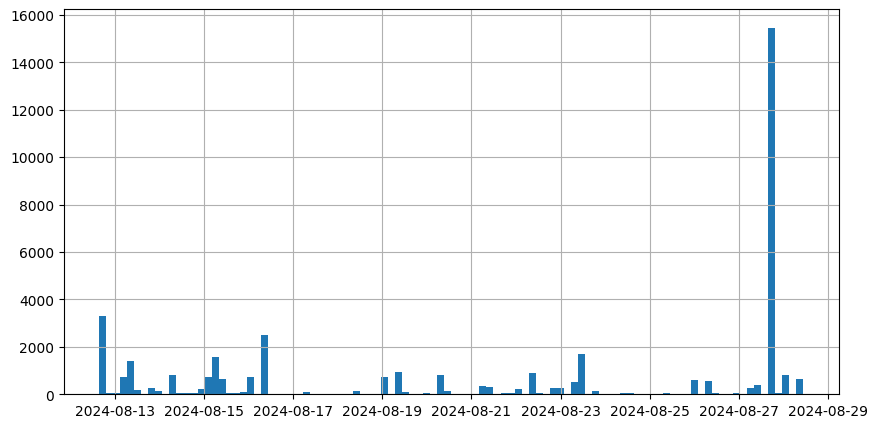

In [ ]:
# histogram
df['angelegt'].hist(bins=100, figsize=(10, 5))


Text(0, 0.5, 'Anzahl der verfügbaren Termine')

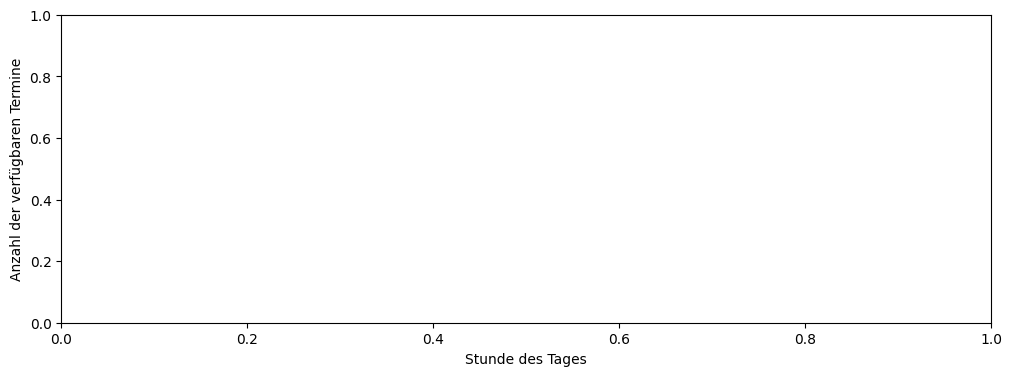

In [ ]:
fig, axs = plt.subplots(figsize=(12,4))

# group by hour of the day
# df.groupby(df['erstmalsErfasstAlsFrei'].dt.hour).size().plot(kind='bar', ax=axs)

plt.xlabel('Stunde des Tages')
plt.ylabel('Anzahl der verfügbaren Termine')

KeyError: 'erstmalsErfasstAlsFrei'

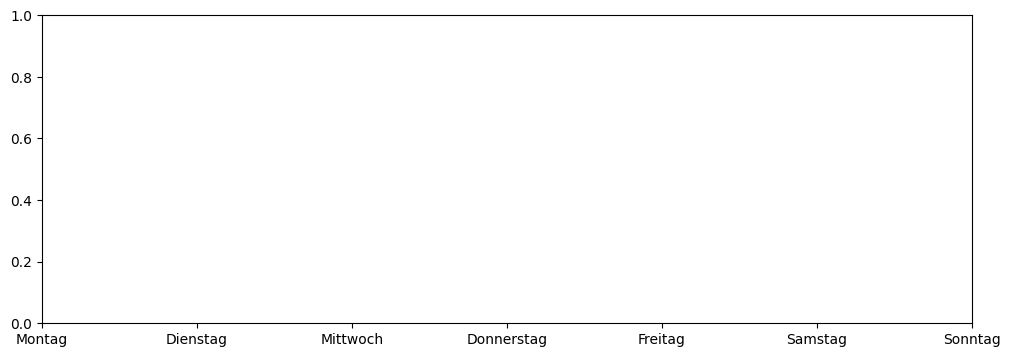

In [ ]:
fig, axs = plt.subplots(figsize=(12,4))


axs.set_xticks(range(7))
axs.set_xticklabels(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])

df.groupby(df['erstmalsErfasstAlsFrei'].dt.dayofweek).size().plot(kind='bar', ax=axs)

plt.xlabel('Tag der Woche')
plt.ylabel('Anzahl der verfügbaren Termine')